In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0418 13:27:02.650438 139727724291904 file_utils.py:38] PyTorch version 1.4.0 available.
I0418 13:27:02.651617 139727724291904 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 1


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased")

I0418 13:27:04.594387 139727724291904 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt from cache at /home/CompanyAI/.cache/torch/transformers/bb773818882b0524dc53a1b31a2cc95bc489f000e7e19773ba07846011a6c711.535306b226c42cebebbc0dabc83b92ab11260e9919e21e2ab0beb301f267b4c7
I0418 13:27:05.647269 139727724291904 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/CompanyAI/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.c7892120c5a9b21e515abc904e398dbabddf9510b122f659063cbf361fe16868
I0418 13:27:05.649232 139727724291904 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 

In [60]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 128
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [61]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[MASK]', '[CLS]', '[PAD]', '[UNK]', '[SEP]'] 
 [103, 101, 0, 100, 102]
[101, 1174, 26646, 49345, 13045, 35132, 25169, 47024, 117, 1170, 26646, 11376, 17360, 13212, 79427, 102]
[101, 29155, 10228, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] hello world [SEP]


# Korean Movie Review Classification

In [76]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [63]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [67]:
# train_data = train_data[:1000] # for test

train_data_sents = []
train_data_labels = []

for train_sent, train_label in zip(train_data["document"], train_data["label"]):
    try:
        token_sent = tokenizer.encode(clean_text(train_sent))
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(train_sent))
        continue
        
    train_data_sents.append(token_sent) #append는 빼 놓고 한다.
    train_data_labels.append(train_label)

train_data_sent_pads = pad_sequences(train_data_sents, maxlen=MAX_LEN, padding='post')
train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(train_data_sent_pads), len(train_data_labels)))

Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
Error message: expected string or bytes-like object
sentence: nan
num sents, labels 149995, 149995


In [68]:
print(train_data_sent_pads[0])

[  101  1174 25539 23236 29234 13045 87550 97082 25539  1176 25539 24937
 13045 16801 72197 47024  1169 70724 22585 13926   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [69]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [71]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=3)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_data_sent_pads, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

data_out/KORtf2_bert_naver_movie -- Folder create complete 

Train on 119996 samples, validate on 29999 samples
Epoch 1/20
119936/119996 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.7509
Epoch 00001: val_accuracy improved from -inf to 0.82812, saving model to data_out/KORtf2_bert_naver_movie/weights.01-0.83.h5
119996/119996 [==============================] - 1060s 9ms/sample - loss: 0.4656 - accuracy: 0.7509 - val_loss: 0.0033 - val_accuracy: 0.8281
Epoch 2/20
119936/119996 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8553
Epoch 00002: val_accuracy improved from 0.82812 to 0.84766, saving model to data_out/KORtf2_bert_naver_movie/weights.02-0.85.h5
119996/119996 [==============================] - 1034s 9ms/sample - loss: 0.3244 - accuracy: 0.8553 - val_loss: 0.0030 - val_accuracy: 0.8477
Epoch 3/20
119936/119996 [============================>.] - ETA: 0s - loss: 0.2764 - accuracy: 0.8814
Epoch 00003: val_accuracy did not improve fro

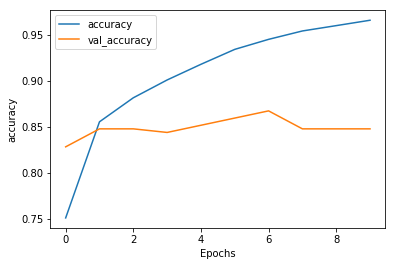

In [72]:
plot_graphs(history, 'accuracy')

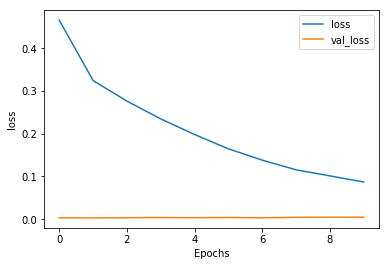

In [73]:
plot_graphs(history, 'loss')

# Korean Movie Review Test 데이터

In [77]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [78]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in zip(test_data["document"], test_data["label"]):
    try:
        token_sent = tokenizer.encode(clean_text(test_sent))
        test_data_sents.append(token_sent)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_data_sent_pad = pad_sequences(test_data_sents, maxlen=MAX_LEN, padding='post') # convert into numpy
test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_data_sent_pad), len(test_data_labels)))

expected string or bytes-like object
nan
expected string or bytes-like object
nan
expected string or bytes-like object
nan
num sents, labels 49997, 49997


In [79]:
results = model.evaluate(test_data_sent_pad, test_data_labels)
print("test loss, test acc: ", results)

49997/49997 [==============================] - 213s 4ms/sample - loss: 0.4673 - accuracy: 0.8568
test loss, test acc:  [0.4673143170114865, 0.85679144]


# KorNLI Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [100]:
# BASE PARAM

BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
# MAX_LEN = 14 * 2 # Average total * 2
MAX_LEN = 65 # Average total * 2

In [81]:
# Load Train dataset
TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [82]:
# SNLI Train Dataset
train_data_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [83]:
# XNLI Train Dataset
train_data_xnli.head()

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


In [84]:
# XNLI DEV Dataset
dev_data_xnli.head()

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction


In [85]:
# 학습을 위하여 SNLI와 XNLI 데이터셋을 합친다.

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.reset_index()

print("Total # dataset: {}".format(len(train_data_snli_xnli)))

Total # dataset: 942854


In [101]:
# Simliarty tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def sim_tokenizer(sent1, sent2, MAX_LEN):
    
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        text = sent1,                      # Sentence to encode.
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
    )
    
    input_id = encoded_dict['input_ids'] # Add the encoded sentence to the list.
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # diffenciate two sentences
    
    return input_id, attention_mask, token_type_id

In [102]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
FILTERS = "([~.,!?\"':;)(])"

change_filter = re.compile(FILTERS)

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id, attention_mask, token_type_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    
train_snli_xnli_input_ids = np.array(input_ids, dtype=int)
train_snli_xnli_attention_masks = np.array(attention_masks, dtype=int)
train_snli_xnli_type_ids = np.array(token_type_ids, dtype=int)
train_snli_xnli_inputs = (train_snli_xnli_input_ids, train_snli_xnli_attention_masks, train_snli_xnli_type_ids)

In [103]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_snli_xnli_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(train_snli_xnli_input_ids), len(train_snli_xnli_labels)))

# sents: 942854, # labels: 942854


In [104]:
# Dev set도 똑같은 방법으로 구성한다.

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id, attention_mask, token_type_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    
dev_xnli_input_ids = np.array(input_ids, dtype=int)
dev_xnli_attention_masks = np.array(attention_masks, dtype=int)
dev_xnli_type_ids = np.array(token_type_ids, dtype=int)
dev_xnli_inputs = (dev_xnli_input_ids, dev_xnli_attention_masks, dev_xnli_type_ids)

In [105]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_xnli_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(dev_xnli_input_ids), len(dev_data_xnli_labels)))

# sents: 2490, # labels: 2490


In [91]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [98]:
#학습 진행하기
model_name = "tf2_KorNLI"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_snli_xnli_input_ids, train_snli_xnli_labels, epochs=NUM_EPOCHS,
                    validation_split = 0.1,
#             validation_data = (dev_xnli_inputs, dev_data_xnli_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

data_out/KORtf2_KorNLI -- Folder already exists 

Train on 848568 samples, validate on 94286 samples
Epoch 1/20
 81408/848568 [=>............................] - ETA: 30:43 - loss: nan - accuracy: 0.3372

W0419 02:50:35.940788 139727724291904 callbacks.py:1286] Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy
W0419 02:50:35.942330 139727724291904 callbacks.py:1018] Can save best model only with val_accuracy available, skipping.


KeyboardInterrupt: 

# KorNLI Test dataset

In [ ]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [ ]:
# Test set도 똑같은 방법으로 구성한다.

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id, attention_mask, token_type_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    
test_xnli_input_ids = np.array(input_ids, dtype=int)
test_xnli_attention_masks = np.array(attention_masks, dtype=int)
test_xnli_type_ids = np.array(token_type_ids, dtype=int)
test_xnli_inputs = (test_xnli_input_ids, test_xnli_attention_masks, test_xnli_type_ids)

In [ ]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_xnli_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_xnli_input_ids), len(test_data_xnli_labels)))

In [ ]:
results = model.evaluate(test_xnli_inputs, test_data_xnli_labels)
print("test loss, test acc: ", results)